# Scalar advection-diffusion using sequential timestepping

We will solve scalar advection-diffusion using serial timestepping and the implicit theta method.

Scalar advection-diffusion is a model linear PDE describing the transport of a passive scalar $q$ by a specified velocity field $u$ and diffusion with a coefficient $\nu$:

$$
\partial_{t}q + u\partial_{x}q - \nu\partial^{2}_{xx}q = 0
$$

We will often combine the two gradient terms into a single spatil residual term:
$$
\partial_{t}q + \textbf{K}q = 0
$$


## Time discretisation

The implicit theta method is a single-step method which includes the first order forward and backward Euler methods, and the second order trapezium rule method as special cases.

The solution $q$ is discretised in time, with the discrete solution $q^{n}$ approximating $q(t^{n})$, where $t^{n}=n\Delta t$ and $\Delta t$ is the timestep size. The implicit theta method provides an update from the current timestep $q^{n}$ to the next timestep $q^{n+1}$ by:

$$
\frac{q^{n+1}-q^{n}}{\Delta t} + \theta \textbf{K}q^{n+1} + (1-\theta)\textbf{K}q^{n} = 0
$$

The time derivative is approximated using simple finite differences, and the right hand side is approximated by a weighted sum of the values at the current and next timestep. When $\theta=0$ we have the explicit forward Euler method, when $\theta=1$ we have the implicit backward Euler method, and when $\theta=0.5$ we have the trapezium rule.

## Implementing the discretisation

Now that we have a timestepping method, we can begin implementing it to find a time series of the solution.
We will solve the advection diffusion equation on a periodic 1D domain. The spatial gradient terms will be implemented using finite differences, so the domain will be split into a number of discrete mesh points.
First we define the number of timesteps `nt`, the number of mesh points `nx`, the size of the domain `lx`.

The velocity is enforced to be 1 everywhere, and the viscosity $\nu$ is calculated by enforcing the Reynolds number $Re=uL/\nu$, which describes whether advection or diffusion forces dominate. $Re\gg1$ will give an advection dominated flow which will not decay quickly.

The timestep is calculated by enforcing the CFL number $\sigma=u\delta t/\delta x$. If $\sigma<1$ then the advection velocity has travelled less than the distance between mesh points $\delta x$ within one timestep, which will give higher accuracy than $\sigma>1$.

In [1]:
nt = 256
nx = 512

lx = 256.
dx = lx/nx

# width of initial profile
width = lx/4

theta = 0.5

# velocity, CFL, and reynolds number
u = 1
re = 200
cfl = 0.4

# viscosity
nu = width*u/re

# timestep
dt = cfl*dx/u

cfl_u = cfl
cfl_v = nu*dt/dx**2

print("nu, dt, cfl_v, cfl_u")
print( nu, dt, cfl_v, cfl_u )

nu, dt, cfl_v, cfl_u
0.32 0.2 0.256 0.4


The domain is $x\in[-l_{x}/2, l_{x}/2]$ and will be discretised by `nx` equally spaced grid points.

In [2]:
import numpy as np

x = np.linspace(start=-lx/2, stop=lx/2, num=nx, endpoint=False)

The spatial derivative can be approximated by second order finite differences:

$$
\partial_{x}q|_{i} \approx \frac{q_{i+1}-q_{i-1}}{2\Delta x} + \mathcal{O}(\Delta x^{2})
$$
and for the second derivative:
$$
\partial^{2}_{xx}q|_{i} \approx \frac{q_{i+1}-2q_{i}+q_{i-1}}{\Delta x^{2}} + \mathcal{O}(\Delta x^{2}),
$$
where $q_{i}$ is the approximation of the solution at grid point $i$.

Rearranging the implicit theta rule method, at each timestep $n$ we can use the solution vector at the current timestep $q^{n}$ to calculate the solution vector at the next timestep $q^{n+1}$ by solving the implicit system:
$$
\left(I + \Delta t\theta K\right)q^{n+1}
= \left(I - \Delta t\left(1-\theta\right)K\right)q^{n}
$$

Where $I$ is the identity matrix and the matrix $K$ contains the finite difference stencils. For a periodic domain $K$ is a circulant matrix, which means that we can reuse the `CirculantLinearOperator` that we implemented to solve the all-at-once system of the Dalhquist equation.

To do this we need to describe the first column of $K$, then of the matrices on the left and right hand side of our update equation:

In [3]:
# identity
I = np.zeros_like(x)
I[0] = 1

# gradient matrix for the advection term
Ka = np.zeros_like(x)
Ka[-1] = 1/(2*dx)
Ka[1] = -1/(2*dx)

# laplacian matrix for the diffusion term
Kd = np.zeros_like(x)
Kd[-1] = 1/dx**2
Kd[0] = -2/dx**2
Kd[1] = 1/dx**2

# full spatial residual matrix
K = u*Ka - nu*Kd

# columns of the right/left hand side matrices
rhs_col = I - dt*(1-theta)*K
lhs_col = I + dt*theta*K

You can convince yourself that these columns do in fact give the correct matrices by setting `nx` small and using [scipy.linalg.circulant](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.circulant.html) to create the full matrices.

Because we need to multiply by a circulant matrix to calculate the right hand side, as well as solve the circulant matrix on the left hand side, the `CirculantLinearOperator` class will need extending. Complete the extra `_mul` method below to implement this.

_Note that we need to specify returning the real component of the vector in `_matvec` because the FFT functions will return complex vectors._

In [4]:
from scipy.sparse import linalg as spla
from scipy.fft import fft, ifft

class CirculantLinearOperator(spla.LinearOperator):
    def __init__(self, col, inverse=True):
        self.dtype = col.dtype
        self.shape = tuple((len(col), len(col)))
        self.col = col
        self.eigvals = fft(col, norm='backward')
        
        if inverse:
            self.op = self._solve
        else:
            self.op = self._mul
    
    def _mul(self, v):
        return ifft(fft(v)*self.eigvals)
    
    def _solve(self, v):
        return ifft(fft(v)/self.eigvals)

    def _matvec(self, v):
        return self.op(v).real

We can now create a linear operator for each side of the equation:

In [5]:
rhs = CirculantLinearOperator(rhs_col, inverse=False)
lhs = CirculantLinearOperator(lhs_col, inverse=True)

With the numerical scheme created, we can now set up the initial conditions using an isolated sinusoidal bump:

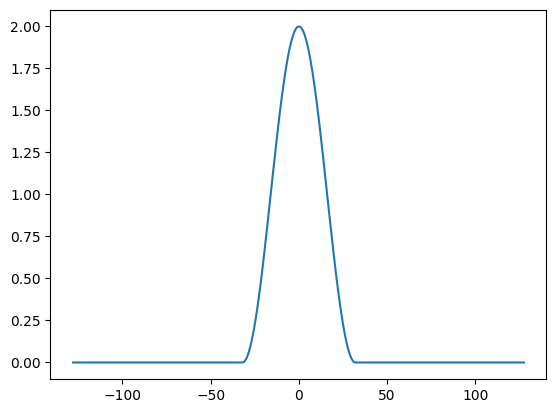

In [6]:
from math import pi
import matplotlib.pyplot as plt

qinit = np.zeros_like(x)
qinit[:] =  1 + np.cos(np.minimum(2*pi*np.abs(x)/width, pi))

plt.plot(x, qinit)
plt.show()

Finally, we can solve the timeseries one step at a time, saving the solution at each timestep along the way.

In [7]:
q = np.zeros((nt+1, nx))
q[0] = qinit

for i in range(1, nt+1):
    q[i] = lhs.matvec(rhs.matvec(q[i-1]))   

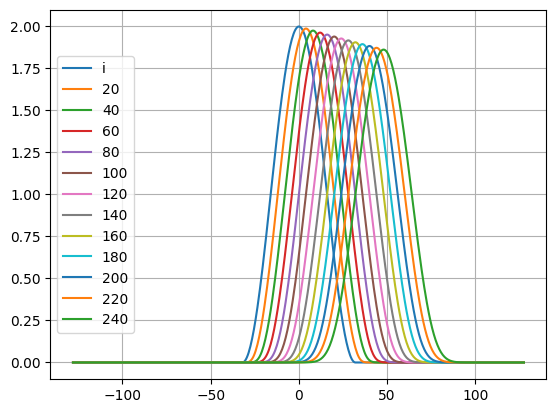

In [8]:
plt.plot(x, qinit, label='i')
for i in range(20, nt+1, 20):
    plt.plot(x, q[i], label=str(i))
plt.legend(loc='center left')
plt.grid()
plt.show()